# MP4

In this assignment you will be performing part segmentation on 3D point clouds. We've provided the dataset and some helper code to guide you along.

Reminders:
- When first getting your code to run do not use GPU as this will exhaust your colab resources
- When you're ready to properly test your models, make sure you are connected to a GPU runtime as this does significantly speeds up execution
    - To change your runtime do: **Runtime** --> **Change runtime type** --> under **Hardware accelerator** select **GPU**
    - Note that changing runtime resets your kernel (meaning you will need to rerun cells and local variables will be lost)
    - It also sets this new runtime as the default when you return to this notebook later
- Do not start last minute, these models do take some time to train
- Unzipping the data takes some time, you should only have to do this once

## Accessing the data

There are multiple ways to work with data in colab.
See this [Colab notebook](https://colab.research.google.com/notebooks/io.ipynb) or this [StackOverflow post](https://stackoverflow.com/questions/48376580/google-colab-how-to-read-data-from-my-google-drive) for more details.

Once you've mounted your drive you can see your entire drive file structure by clicking the "Files" tab on the left.

**If you wish to work locally you can ignore the first three cells, but you will still need to set the appropriate path for your dataset**

In [1]:
# # # Note there are other methods to do this
# from google.colab import drive
# drive.mount('/content/gdrive/')

# import os
# if not os.path.exists("/content/gdrive/My Drive/CS_498_MP4"):
#     os.makedirs("/content/gdrive/My Drive/CS_498_MP4")
# os.chdir("/content/gdrive/My Drive/CS_498_MP4")

In [2]:
# Replace path with wherever you put the zip
# !unzip "/content/gdrive/My Drive/Intro to machine perception/shapenet_partseg.zip" -d ./

In [3]:
# Colab will not have open3d by default, we need to install it
# !pip install open3d

In [4]:
# TODO: make sure to specify the right dataset path here
DATASET_PATH = './shapenet_partseg/'
# DATASET_PATH = '/content/gdrive/MyDrive/CS_498_MP4/shapenet_partseg/'

In [5]:
from __future__ import print_function

import os
import numpy as np
import sys
import open3d as o3d
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

from tqdm import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Dataset (Q1)

Here we define a class (pytorch Dataset) for accessing data. This allows us to perform transformations on the data (data augmentation) as we access it. Pytorch dataloaders take in a dataset and conventiently deal with the overhead of looping through it in batches. Creating such datasets/loaders significantly simplifies our training code later on.

**PDF: In your pdf visualize the same image (your choice which) a couple times to demonstrate your transformations**



In [6]:
class ShapeNetDataset(data.Dataset):
    def __init__(self,
                 root,
                 npoints=2500,
                 class_choice=None,
                 split='train',
                 data_augmentation=True):
        self.npoints = npoints
        self.root = root
        self.catfile = os.path.join(self.root, 'synsetoffset2category.txt')
        self.cat = {}
        self.data_augmentation = data_augmentation
        self.seg_classes = {}
        
        # 生成一个字典, 是所有的tag和对应文件夹的名称
        with open(self.catfile, 'r') as f:
            for line in f:
                ls = line.strip().split()
                self.cat[ls[0]] = ls[1]
        # print("cat:", self.cat)
        # 选定对应的种类
        if not class_choice is None:
            self.cat = {k: v for k, v in self.cat.items() if k in class_choice}
        # print("cat:", self.cat)
        # 将其转化为文件夹名称: 种类的形式
        self.id2cat = {v: k for k, v in self.cat.items()}
        # print("id2cat", self.id2cat)

        self.meta = {}
        splitfile = os.path.join(self.root, 'train_test_split', 'shuffled_{}_file_list.json'.format(split))
        #from IPython import embed; embed()
        filelist = json.load(open(splitfile, 'r'))
        for item in self.cat:
            self.meta[item] = []
        # print("self.meta", self.meta)

        for file in filelist:
            _, category, uuid = file.split('/')
            if category in self.cat.values():
                self.meta[self.id2cat[category]].append((os.path.join(self.root, category, 'points', uuid+'.pts'),
                                        os.path.join(self.root, category, 'points_label', uuid+'.seg')))
        # print("self.meta2", self.meta)

        self.datapath = []
        for item in self.cat:
            for fn in self.meta[item]:
                self.datapath.append((item, fn[0], fn[1]))
        # print("self.datapath", self.datapath)

        self.classes = dict(zip(sorted(self.cat), range(len(self.cat))))
        with open(os.path.join(root, 'num_seg_classes.txt'), 'r') as f:
            for line in f:
                ls = line.strip().split()
                self.seg_classes[ls[0]] = int(ls[1])
        self.num_seg_classes = self.seg_classes[list(self.cat.keys())[0]]
        # print("self.num_seg_classes", self.num_seg_classes)

    def __getitem__(self, index):
        fn = self.datapath[index]
        cls = self.classes[self.datapath[index][0]]
        point_set = np.loadtxt(fn[1]).astype(np.float32)
        # print("point_set.shape", point_set.shape)
        seg = np.loadtxt(fn[2]).astype(np.int64) - 1  # zero-indexed
        # print("seg", seg)

        # resample
        choice = np.random.choice(len(seg), self.npoints, replace=True)
        point_set = point_set[choice, :]
        
        # normalize
        point_set = point_set - np.expand_dims(np.mean(point_set, axis = 0), 0) # center
        dist = np.max(np.sqrt(np.sum(point_set ** 2, axis = 1)),0)
        point_set = point_set / dist # scale

        if self.data_augmentation: # Perform random rotation and jittering
            # Your code
            # -------------------------
            angle_range = np.pi
            rotation_angle = np.random.uniform(-angle_range, angle_range)
            rotation_matrix = np.array([[np.cos(rotation_angle), 0, np.sin(rotation_angle)],
                                        [0, 1, 0],
                                        [-np.sin(rotation_angle), 0, np.cos(rotation_angle)]])
            point_set = np.dot(point_set, rotation_matrix)

            jitter_range = 0.01
            jitter = np.random.normal(0, jitter_range, size=point_set.shape)
            point_set += jitter
            # -------------------------
            
        seg = seg[choice]
        point_set = torch.from_numpy(point_set.T)
        seg = torch.from_numpy(seg)
        cls = torch.from_numpy(np.array([cls]).astype(np.int64))

        return point_set, seg

    def __len__(self):
        return len(self.datapath)

In [7]:
dataset = ShapeNetDataset(root=DATASET_PATH, split='train', class_choice=['Chair'], data_augmentation=True)
print(len(dataset), 'point clouds')
print(dataset.num_seg_classes, 'classes')
# print("dataset:", dataset[0][1], len(dataset[0][1])) # (2500,3)

2658 point clouds
4 classes


In [8]:
# TODO: set the batch size, when running experiments later you should try different batch sizes
training_batch_size = 16
dataloader = data.DataLoader(dataset, batch_size=training_batch_size, shuffle=True, drop_last=True)

In [9]:
val_dataset = ShapeNetDataset(root=DATASET_PATH, split='val', class_choice=['Chair'], data_augmentation=False)
val_dataloader = data.DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=False)
print(len(val_dataset), 'point clouds')

396 point clouds


In [10]:
# Red, green, blue, cyan
palette = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 1, 1]]

# Visualize a segmented point cloud
def vis_data(pts, seg):
    pts = np.array(pts).T
    seg = np.array(seg)
    pcds = []
    for i in np.unique(seg):
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(pts[seg == i])
        pcd.colors = o3d.utility.Vector3dVector([palette[i]] * len(pcd.points))
        pcds.append(pcd)
    o3d.visualization.draw_plotly(pcds)

In [11]:
# Visualize a couple of chairs
for i in range(2):
    pts, seg = dataset[i]
    vis_data(pts, seg)

In [12]:
# TODO: Based on what you visualized, replace 0, 1, 2, 3 with names for each part class, e.g. "legs", "seat"
classes = [
    'back',
    'seat',
    'leg',
    'armrest'
]

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device("mps")
device

'cuda'

In [14]:
# for i, data in tqdm(enumerate(dataloader, 0), total=len(dataloader)):
#     # Your code
#     # -------------------------
#     inputs, labels = data
#     print("input: ", inputs.shape)
#     print("labels: ",labels.shape)

## Simple Baseline (Q2)

This is a simple hand-crafted segmentor for chair parts. It cuts each input point cloud into thirds and assigns the top third as the chair back, the middle third as the chair seat, and the bottom third as the chair legs. Implement this baseline model in `simple_model`. Also implement a function that makes predictions over a dataset in `simple_predict`.

Note that the model should take in a _batch_ of point clouds, and return a distribution over the classes for each point. For this simple model, the distribution should be one-hot, e.g. 1 in the predicted class index and zero elsewhere.

**PDF: in your pdf report the evaluation metrics (from the next question) for this simple baseline. Also visualize a couple outputs from the model.**

In [15]:
from torch.types import Device
# Question 2
def simple_model(pts_batch, n_classes):
    batch_size, n_pts = pts_batch.shape[0], pts_batch.shape[2] # pts_batch(16,3,2500)
    
    # Make sure you understand each axis of this shape
    pred_seg = torch.zeros(batch_size, n_classes, n_pts, dtype=torch.uint8, device=pts_batch.device)#.to(device)
    
    # Your code
    # -------------------------
    third = int(n_pts / 3)
    bottom_third = int(2 * n_pts / 3)

    for batch in range(batch_size):
      y_values = pts_batch[batch,1,:].to(device)
      sorted_indices = torch.argsort(y_values, descending = True).to(device) # 从大到小排列
      top_third_y_value = y_values[sorted_indices[third]].to(device)
      bottom_third_y_value = y_values[sorted_indices[bottom_third]].to(device)
      pred_seg[batch, 0, y_values>=top_third_y_value] = 1
      pred_seg[batch, 1, ((y_values<top_third_y_value) & (y_values>=bottom_third_y_value))] = 1
      pred_seg[batch, 2, y_values<bottom_third_y_value] = 1
    
    # y_values = pts_batch[:, 1, :]
    # sorted_indices = torch.argsort(y_values, dim=1, descending=True) # 从大到小排列
    # top_third_y_value = y_values.gather(1, sorted_indices[:, third].unsqueeze(1)).squeeze(1)
    # bottom_third_y_value = y_values.gather(1, sorted_indices[:, bottom_third].unsqueeze(1)).squeeze(1)
    # pred_seg[:, 0, y_values>=top_third_y_value] = 1
    # pred_seg[:, 1, ((y_values<top_third_y_value) & (y_values>=bottom_third_y_value))] = 1
    # pred_seg[:, 2, y_values<bottom_third_y_value] = 1
    # -------------------------
    return pred_seg

def simple_predict(dataloader, n_classes):
    gts, preds = [], []
    for i, batch in enumerate(tqdm(dataloader)):
        # Your code
        # -------------------------
        data, label = batch
        # print("data:", type(data))
        # print("lable", type(label))
        data, label = data.to(device), label.to(device) 
        batch_size = label.shape[0]
        pred_seg = simple_model(data, n_classes)#.to(device)
        gt_seg = torch.zeros(pred_seg.shape[0], pred_seg.shape[2])#.to(device)
        
        for batch in range(batch_size):
          # gt_seg[batch, 0, label[batch]==0] = 1
          # gt_seg[batch, 1, label[batch]==1] = 1
          # gt_seg[batch, 2, label[batch]==2] = 1
          # gt_seg[batch, 3, label[batch]==3] = 1

          gt_seg[batch, label[batch]==0] = 0
          gt_seg[batch, label[batch]==1] = 1
          gt_seg[batch, label[batch]==2] = 2
          gt_seg[batch, label[batch]==3] = 3

        # gt_seg[:, 0, label==0] = 1
        # gt_seg[:, 1, label==1] = 1
        # gt_seg[:, 2, label==2] = 1
        # gt_seg[:, 3, label==3] = 1
        if gts == []:
          gts = gt_seg.cpu()
          preds = pred_seg.cpu()
        else:
          gts = torch.cat([gts, gt_seg.cpu()],0)
          preds = torch.cat([preds, pred_seg.cpu()],0)
        # -------------------------
    return np.array(gts), np.array(preds)

In [16]:
# Make predictions using our simple model
gts, baseline_preds = simple_predict(dataloader, len(classes))

100%|██████████| 166/166 [01:51<00:00,  1.49it/s]


In [17]:
gts.shape, baseline_preds.shape

((2656, 2500), (2656, 4, 2500))

## Evaluation Metrics (Q3)

We've implemented mean average precision. Your job is to compute the confusion matrix and IoU for a set of predictions. Namely, fill in the compute_confusion_matrix function.

The **(i,j)** th entry of a confusion matrix computes the number of observations known to be in group **i** and predicted to be in group **j**. You can use [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) as a reference and sanity check.

IoU is the intersection of the predicted and ground truth segmentation masks divided by their union. Think how these values are related to what you've already computed in the confusion matrix. 

In [18]:
def segmentation_eval(gts, preds, classes, plot_file_name):
    """
    @param    gts               numpy.ndarray   ground truth labels
    @param    preds             numpy.ndarray   predicted labels
    @param    classes           string          class names
    @param    plot_file_name    string          plot file names
    """
    ious, counts = compute_confusion_matrix(gts, preds)
    aps = compute_ap(gts, preds)
    plot_results(counts, ious, aps, classes, plot_file_name)
    for i in range(len(classes)):
        print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format(classes[i], aps[i], ious[i]))
    print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format('mean', np.mean(aps), np.mean(ious)))
    return aps, ious

def plot_results(counts, ious, aps, classes, file_name):
    fig, ax = plt.subplots(1,1)
    conf = counts / np.sum(counts, 1, keepdims=True)
    conf = np.concatenate([conf, np.array(aps).reshape(-1,1), 
                           np.array(ious).reshape(-1,1)], 1)
    conf = conf * 100.
    sns.heatmap(conf, annot=True, ax=ax, fmt='3.0f') 
    arts = [] 
    # labels, title and ticks
    _ = ax.set_xlabel('Predicted labels')
    arts.append(_)
    _ = ax.set_ylabel('True labels')
    arts.append(_)
    _ = ax.set_title('Confusion Matrix, mAP: {:5.1f}, mIoU: {:5.1f}'.format(
      np.mean(aps)*100., np.mean(ious)*100.))
    arts.append(_)
    _ = ax.xaxis.set_ticklabels(classes + ['AP', 'IoU'], rotation=90)
    arts.append(_)
    _ = ax.yaxis.set_ticklabels(classes, rotation=0)
    arts.append(_)
    if file_name is not None:
        fig.savefig(file_name, bbox_inches='tight')
    else:
        plt.show()

def compute_ap(gts, preds):
    aps = []
    for i in range(preds.shape[1]):
        ap, prec, rec = calc_pr(gts == i, preds[:, i:i+1, :])
        aps.append(ap)
    return aps

def calc_pr(gt, out, wt=None):
    gt = gt.astype(np.float64).reshape((-1,1))
    out = out.astype(np.float64).reshape((-1,1))
    tog = np.concatenate([gt, out], axis=1)*1.
    ind = np.argsort(tog[:,1], axis=0)[::-1]
    tog = tog[ind,:]
    cumsumsortgt = np.cumsum(tog[:,0])
    cumsumsortwt = np.cumsum(tog[:,0]-tog[:,0]+1)
    prec = cumsumsortgt / cumsumsortwt
    rec = cumsumsortgt / np.sum(tog[:,0])
    ap = voc_ap(rec, prec)
    return ap, rec, prec

def voc_ap(rec, prec):
    rec = rec.reshape((-1,1))
    prec = prec.reshape((-1,1))
    z = np.zeros((1,1)) 
    o = np.zeros((1,1))
    mrec = np.vstack((z, rec, o))
    mpre = np.vstack((z, prec, z))
    mpre = np.maximum.accumulate(mpre[::-1])[::-1]
    I = np.where(mrec[1:] != mrec[0:-1])[0]+1;
    ap = np.sum((mrec[I] - mrec[I-1])*mpre[I])
    return ap
    
# Question 3: compute the confusion matrix and IoU metrics
# Hint: once you've computed the confusion matrix, IoU is easy
# Note: preds contains class probabilities, convert this to a class prediction
def compute_confusion_matrix(gts, preds): # (2656, 2500), (2656, 4, 2500)
    # print("gtss shape: ", gts.shape, "preds shape:", preds.shape)
    
    n_classes = preds.shape[1]
    IoU = np.zeros((n_classes))
    conf = np.eye(n_classes)
    # Your code
    # ----------------------
    for i in range(n_classes):
      for j in range(n_classes):
        conf[i, j] = np.sum(np.logical_and(gts == i, preds[:,j,:] == preds.max(axis = 1))) 
    intersection = np.diag(conf)
    union = np.sum(conf, axis=0) + np.sum(conf, axis=1) - np.diag(conf)
    IoU = intersection / union
    # ----------------------
    return IoU, conf

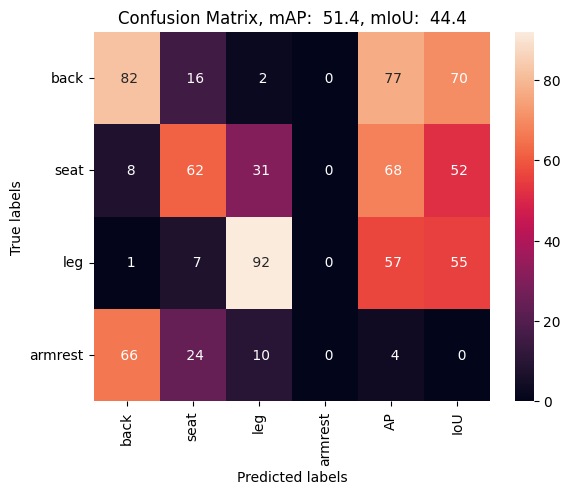

                back: AP: 0.77, IoU: 0.70
                seat: AP: 0.68, IoU: 0.52
                 leg: AP: 0.57, IoU: 0.55
             armrest: AP: 0.04, IoU: 0.00
                mean: AP: 0.51, IoU: 0.44


In [19]:
# Evaluate our trivial segmentor
aps, ious = segmentation_eval(gts, baseline_preds, classes, plot_file_name=None)

## Loss function (Q4)

Implement the weighted cross entropy loss. 

You may not call nn.CrossEntropy but can use it as a good reference and sanity check.

**PDF: in your pdf please describe the cross entropy loss. Also explain the purpose of using a weighted loss.**

In [20]:
import copy
def cross_entropy_criterion(predictions, labels, weights):
    #predictions: (16,4,2500)
    # labels: (16,2500) 0,1,2,3
    # Your code
    # ----------------------
    predictions = predictions.transpose(1,2)
    predictions = predictions.contiguous().view(-1, predictions.size(2))
    # print(predictions.is_contiguous())
    # print(predictions.shape) # ([40000, 4])
    log_softmax = F.log_softmax(predictions, dim=1) # (40000, 4)
    weights = torch.tensor(weights).to(device)
    # print(weights.shape) # (1,4)
    predictions_value = torch.mul(weights, log_softmax)
    # print(predictions_value.shape) # (40000, 4)

    labels = labels.view(1, -1)
    # print("labels:", labels[:5])
    element = torch.arange(0, labels.shape[1]).to(device)
    # print("element:", element[:5])
    labels = labels + element * predictions.shape[1]
    # print("labels:", labels[:5])
    loss = -1 * torch.take(predictions_value, labels)
    # print("loss:", loss)
    # ----------------------
    return loss.mean()

## Training loop (Q5)

Fill in the training loop. We've provided validation code as well as skeleton code for training.

Keep in mind that you need to move data onto the device (GPU) as you cycle through the dataloader

While we've provided you with a skeleton to fill in, you should feel free to modify the visualization code for debugging purposes. For example you might want to print out the loss each iteration instead of once per epoch. Or you might want to compute validation accuracy metrics (like IoU) instead of just validation loss.

**PDF: in your pdf please describe why it is important to consider both validation and training losses simultaneously. When loss stops decreasing, can we change something about the training parameters to continue improving the model?**

In [21]:
def validate_model(val_loader, model, classes, device, show_matrix=False):
    model.eval()
    preds = np.array([]).reshape(0, len(classes), 2500)
    gts = np.array([]).reshape(0, 2500)
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs = inputs.to(device, dtype=torch.float)
            # outputs = model(inputs).transpose(1,2)
            # outputs = outputs.cpu().numpy() # torch.Size([32, 4, 2500])

            outputs = model(inputs).cpu().numpy() # torch.Size([32, 4, 2500])

            preds = np.concatenate([preds, outputs], axis=0)
            gts = np.concatenate([gts, labels.numpy()], axis=0)
            
            print("Validating...{}\r".format(100.0*len(preds)/len(val_loader)), end="")
    
    if show_matrix:
        aps, ious = segmentation_eval(gts, preds, classes, None)
    else:
        ious, counts = compute_confusion_matrix(gts, preds)
        aps = compute_ap(gts, preds)
        for i in range(len(classes)):
            print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format(classes[i], aps[i], ious[i]))
        print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format('mean', np.mean(aps), np.mean(ious)))

    return preds, gts

# Your goal is to complete this function
def train(model, optimizer, criterion, trainloader, device, valloader=None, epochs=15):
    train_loss_over_epochs = []
    val_loss_over_epochs = []
    plt.ioff()
    fig = plt.figure()
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=3, gamma=0.1)
    for epoch in range(epochs):
        model.train()
        # running loss is the **average** loss for each item in the dataset during this epoch
        running_loss = 0.0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            # Your code
            # -------------------------
            train_inputs, train_labels = data
            train_inputs, train_labels = train_inputs.float().to(device, dtype=torch.float), train_labels.to(device)
            # print("input shape: ", type(inputs))
            optimizer.zero_grad()

            train_outputs = model(train_inputs)
            train_loss = criterion(train_outputs, train_labels)
            train_loss.backward()
            optimizer.step()

            running_loss += train_loss.item() / len(trainloader)
        # scheduler.step()
            # -------------------------

        train_loss_over_epochs.append(running_loss)

        # If you pass in a validation dataloader then compute the validation loss
        if not valloader is None:
            val_loss = 0.0
            model.eval()
            with torch.no_grad():
                for data in valloader:
                    # Your code
                    # -------------------------
                    val_images, val_labels = data
                    val_images, val_labels = val_images.to(device, dtype=torch.float), val_labels.to(device)
                    val_outputs = model(val_images)
                    valid_loss = criterion(val_outputs, val_labels)
                    val_loss += valid_loss.item() / len(valloader)
                    # pass
                    # -------------------------
            val_loss_over_epochs.append(val_loss)
            print('Epoch: {}, training loss: {:.3f}, val loss: {:.3f}'.format(epoch + 1, running_loss, val_loss))
        else:
            # Note: it can be more readable to overwrite the previous line - end="\r"
            print('Epoch: {}, training loss: {:.3f}'.format(epoch + 1, running_loss))
        
    plt.subplot(2, 1, 1)
    plt.ylabel('Loss')
    plt.plot(np.arange(epochs), train_loss_over_epochs, color='red', label='train')
    if not valloader is None:
        plt.plot(np.arange(epochs), val_loss_over_epochs, color='blue', label='val')
    plt.title('Loss per Epoch')
    plt.xticks(np.arange(epochs, dtype=int))
    plt.grid(True)
    plt.legend()
    plt.show()
    return model


## Model definitions (Q6)

We will now define our model architecture. Implement the PointNet segmentation network described in https://arxiv.org/pdf/1612.00593.pdf (see Fig. 2). You may ignore the "input transform" and "feature transform" for now; these will be left as bonus.

Some things to keep in mind:
- feel free to modify the architecture, as long as you are following the same overall structure
- nn.Conv1D with kernel size 1 can serve as a shared mlp
- nn.BatchNorm1d is incredibly helpful, make sure to include it between layers
- you can stick to ReLU activations, but are welcome to report results with other activation functions
- the model output should be class probabilities

**PDF: in your pdf please describe your final model architectures. Report the training plots and final accuracy metrics on the validation set for each model. What batch size, learning rate, optimizer did you find works best? Perform a small ablation study: what is the effect of batchnorm on training speed and accuracy? Visualize a few point clouds with their predicted segmentations by your model.**

In [22]:
# TODO: Implement the model
from torch.autograd import Variable

class transform(nn.Module):
    def __init__(self, k):
        super(transform, self).__init__()
        self.transform1 = torch.nn.Sequential(
            nn.Conv1d(k, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        self.transform2 = torch.nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, k*k)
        )
        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = self.transform1(x)
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        x = self.transform2(x)
        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1,self.k*self.k).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

class PointNetSeg(nn.Module):
    def __init__(self, k = 4):
        super(PointNetSeg, self).__init__()
        self.k = k
        self.input_transform = transform(k=3)
        self.net1 = nn.Sequential(
            nn.Conv1d(3, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.feature_transform = transform(k=64)
        self.net2 = nn.Sequential(
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024)
        )
        self.segnet = nn.Sequential(
            nn.Conv1d(1088, 512, 1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Conv1d(512, 256, 1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, self.k, 1)
        )

    def forward(self, x):
        batchsize = x.size()[0]
        n_pts = x.size()[2]
        trans = self.input_transform(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = self.net1(x)
        trans_feat = self.feature_transform(x)
        x = x.transpose(2,1)
        x = torch.bmm(x, trans_feat)
        x = x.transpose(2,1)
        pointfeat = x
        x = self.net2(x)
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024, 1).repeat(1, 1, n_pts)
        x = torch.cat([x, pointfeat], 1)
        x = self.segnet(x)
        x = x.transpose(2,1).contiguous()
        x = F.log_softmax(x.view(-1,self.k), dim=-1)
        x = x.view(batchsize, n_pts, self.k)
        x = x.transpose(1,2)
        return x

In [23]:
# sim_data = Variable(torch.rand(16,3,2500))
# seg = PointNetSeg(k=4)
# output = seg(sim_data)
# output.size()

### Now we can finally train our models...

In [24]:
# if runtime has GPU use GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

# device = torch.device("mps")
print("Using device:", device)

Using device: cuda:0


In [25]:
# Calculate class weights based on frequency of appearance in ground truth
class_weights = []
for c in range(len(classes)):
    class_weights.append(1/np.sqrt(np.mean(gts==c)))
print(class_weights)
# class_weights

[1.7198810250251724, 1.5515740269933709, 2.1770125979306583, 5.304029813690292]


100%|██████████| 166/166 [00:59<00:00,  2.81it/s]


Epoch: 1, training loss: 1.150, val loss: 0.688


100%|██████████| 166/166 [00:38<00:00,  4.32it/s]


Epoch: 2, training loss: 0.806, val loss: 0.577


100%|██████████| 166/166 [00:38<00:00,  4.30it/s]


Epoch: 3, training loss: 0.722, val loss: 0.548


100%|██████████| 166/166 [00:38<00:00,  4.29it/s]


Epoch: 4, training loss: 0.670, val loss: 0.509


100%|██████████| 166/166 [00:38<00:00,  4.27it/s]


Epoch: 5, training loss: 0.615, val loss: 0.506


100%|██████████| 166/166 [00:38<00:00,  4.27it/s]


Epoch: 6, training loss: 0.585, val loss: 0.512


100%|██████████| 166/166 [00:38<00:00,  4.27it/s]


Epoch: 7, training loss: 0.573, val loss: 0.447


100%|██████████| 166/166 [00:38<00:00,  4.29it/s]


Epoch: 8, training loss: 0.553, val loss: 0.447


100%|██████████| 166/166 [00:39<00:00,  4.24it/s]


Epoch: 9, training loss: 0.540, val loss: 0.427


100%|██████████| 166/166 [00:38<00:00,  4.26it/s]


Epoch: 10, training loss: 0.521, val loss: 0.411


100%|██████████| 166/166 [00:38<00:00,  4.27it/s]


Epoch: 11, training loss: 0.515, val loss: 0.435


100%|██████████| 166/166 [00:38<00:00,  4.27it/s]


Epoch: 12, training loss: 0.510, val loss: 0.413


100%|██████████| 166/166 [00:39<00:00,  4.25it/s]


Epoch: 13, training loss: 0.484, val loss: 0.379


100%|██████████| 166/166 [00:38<00:00,  4.26it/s]


Epoch: 14, training loss: 0.487, val loss: 0.393


100%|██████████| 166/166 [00:39<00:00,  4.24it/s]


Epoch: 15, training loss: 0.479, val loss: 0.398


100%|██████████| 166/166 [00:38<00:00,  4.28it/s]


Epoch: 16, training loss: 0.484, val loss: 0.497


100%|██████████| 166/166 [00:39<00:00,  4.25it/s]


Epoch: 17, training loss: 0.478, val loss: 0.409


100%|██████████| 166/166 [00:39<00:00,  4.26it/s]


Epoch: 18, training loss: 0.463, val loss: 0.418


100%|██████████| 166/166 [00:38<00:00,  4.26it/s]


Epoch: 19, training loss: 0.457, val loss: 0.376


100%|██████████| 166/166 [00:38<00:00,  4.26it/s]


Epoch: 20, training loss: 0.445, val loss: 0.368


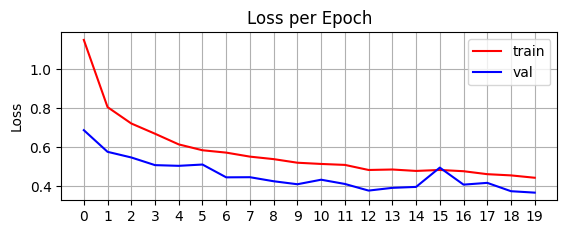

In [26]:
# Train and validate
torch.manual_seed(2023)
np.random.seed(2023)

# First make the model and put it on the device
model = PointNetSeg(k=4).to(device)
# model = PointNetSeg().to(device)

# Now define our loss criterion as cross entropy based on your previous code
criterion = lambda y_pred, y_true: cross_entropy_criterion(y_pred, y_true, class_weights)

# Now make our optimizer for this model
# TODO: pick an optimizer from torch.optim and set the learning rate
lr = None
optimizer = None

lr = 0.01
optimizer = optim.SGD(model.parameters(),lr=lr, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr = lr) 

# TODO: how many epochs to train for?
# Consider putting this code into a loop, 
# thus alternating between training for some number of epochs and validating
# epochs = None
epochs = 20
model = train(model, optimizer, criterion, dataloader, device, valloader=val_dataloader, epochs=epochs)

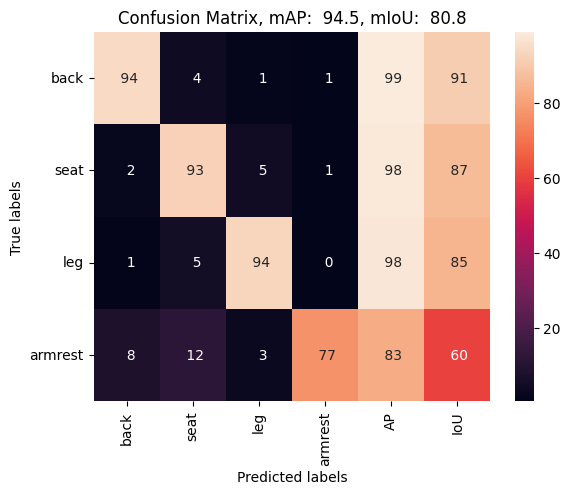

                back: AP: 0.99, IoU: 0.91
                seat: AP: 0.98, IoU: 0.87
                 leg: AP: 0.98, IoU: 0.85
             armrest: AP: 0.83, IoU: 0.60
                mean: AP: 0.95, IoU: 0.81


In [27]:
preds, gts = validate_model(val_dataloader, model, classes, device, show_matrix=True)

In [28]:
# Visualize some predictions
def vis_pred_vs_gt(pts, gt_seg, model):
    with torch.no_grad():
        pred_seg = model(pts.to(device).unsqueeze(0))[0].argmax(0).cpu().numpy()
    pts = np.array(pts).T
    gt_seg = np.array(gt_seg)
    pcds = []
    for i in range(model.k):
        gt_pcd = o3d.geometry.PointCloud()
        gt_pcd.points = o3d.utility.Vector3dVector(pts[gt_seg == i])
        gt_pcd.colors = o3d.utility.Vector3dVector([palette[i]] * len(gt_pcd.points))
        pcds.append(gt_pcd)
        
        pred_pcd = o3d.geometry.PointCloud()
        pred_pts = pts[pred_seg == i].copy()
        pred_pts[:, 0] += 2  # pred cloud is shifted
        pred_pcd.points = o3d.utility.Vector3dVector(pred_pts)
        pred_pcd.colors = o3d.utility.Vector3dVector([palette[i]] * len(pred_pcd.points))
        pcds.append(pred_pcd)
    
    o3d.visualization.draw_plotly(pcds)
    
for i in range(3):
    pts, gt_seg = val_dataset[np.random.randint(len(val_dataset))]
    vis_pred_vs_gt(pts, gt_seg, model)

### Test set

After tuning our model based on the validation results, we can finally check evaluation on test set. Run this code as sparingly as possible, ideally only once -- you should NOT optimize for the test performance.

**PDF: in your pdf report the results of your best model (this should be based on a pretrained model) on the test dataset.**

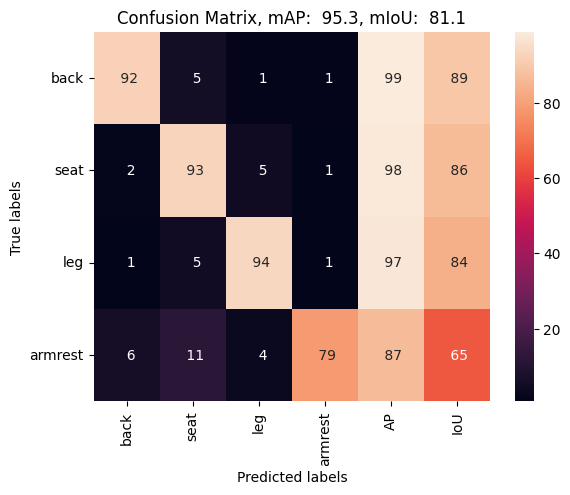

                back: AP: 0.99, IoU: 0.89
                seat: AP: 0.98, IoU: 0.86
                 leg: AP: 0.97, IoU: 0.84
             armrest: AP: 0.87, IoU: 0.65
                mean: AP: 0.95, IoU: 0.81


In [29]:
test_dataset = ShapeNetDataset(root=DATASET_PATH, split='test', class_choice=['Chair'], data_augmentation=False)
test_dataloader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False)
preds, gts = validate_model(test_dataloader, model, classes, device, show_matrix=True)

## Other Object Categories (Q7)

So far we have trained a model for chair part segmentation. However, there are many other object categories available in our dataset. Choose whichever one you like, extract the corresponding data, train a new model for that object category, and report the results. 

Use the `class_choice` argument of the ShapeNetDataset constructor to extract the category you want.

**PDF: Report the training plots and final accuracy metrics on the validation set for your model on the new dataset. What batch size, learning rate, optimizer did you find works best? Also visualize a few point clouds with their predicted segmentations by your model.**

In [30]:
# View available object categories, along with how many part classes they have
print(dataset.seg_classes)

{'Airplane': 4, 'Car': 4, 'Chair': 4, 'Guitar': 3, 'Knife': 2, 'Lamp': 4, 'Laptop': 2, 'Pistol': 3}


In [31]:
# TODO: Use what you learned above to train and evaluate a model on a new category!

plane_dataset = ShapeNetDataset(root=DATASET_PATH, split='train', class_choice=['Airplane'], data_augmentation=True)
plane_dataloader = data.DataLoader(plane_dataset, batch_size=16, shuffle=True, drop_last=True)
plane_val_dataset = ShapeNetDataset(root=DATASET_PATH, split='val', class_choice=['Airplane'], data_augmentation=False)
plane_val_dataloader = data.DataLoader(plane_val_dataset, batch_size=32, shuffle=False, drop_last=False)

In [32]:
class_weights = []
for c in range(len(classes)):
    class_weights.append(1/np.sqrt(np.mean(gts==c)))
print(class_weights)

[1.72036406621229, 1.5511570928814404, 2.177797127644527, 5.295212562734759]


100%|██████████| 122/122 [01:19<00:00,  1.54it/s]


Epoch: 1, training loss: 1.964, val loss: 1.585


100%|██████████| 122/122 [00:28<00:00,  4.31it/s]


Epoch: 2, training loss: 1.256, val loss: 1.000


100%|██████████| 122/122 [00:28<00:00,  4.31it/s]


Epoch: 3, training loss: 1.051, val loss: 1.041


100%|██████████| 122/122 [00:28<00:00,  4.30it/s]


Epoch: 4, training loss: 0.960, val loss: 0.725


100%|██████████| 122/122 [00:28<00:00,  4.28it/s]


Epoch: 5, training loss: 0.887, val loss: 0.683


100%|██████████| 122/122 [00:28<00:00,  4.28it/s]


Epoch: 6, training loss: 0.826, val loss: 0.557


100%|██████████| 122/122 [00:28<00:00,  4.25it/s]


Epoch: 7, training loss: 0.809, val loss: 0.571


100%|██████████| 122/122 [00:28<00:00,  4.27it/s]


Epoch: 8, training loss: 0.760, val loss: 0.558


100%|██████████| 122/122 [00:28<00:00,  4.28it/s]


Epoch: 9, training loss: 0.751, val loss: 0.599


100%|██████████| 122/122 [00:28<00:00,  4.29it/s]


Epoch: 10, training loss: 0.720, val loss: 0.798


100%|██████████| 122/122 [00:28<00:00,  4.31it/s]


Epoch: 11, training loss: 0.692, val loss: 1.104


100%|██████████| 122/122 [00:28<00:00,  4.28it/s]


Epoch: 12, training loss: 0.664, val loss: 0.496


100%|██████████| 122/122 [00:28<00:00,  4.28it/s]


Epoch: 13, training loss: 0.664, val loss: 0.776


100%|██████████| 122/122 [00:28<00:00,  4.31it/s]


Epoch: 14, training loss: 0.646, val loss: 0.600


100%|██████████| 122/122 [00:28<00:00,  4.27it/s]


Epoch: 15, training loss: 0.651, val loss: 0.502


100%|██████████| 122/122 [00:28<00:00,  4.29it/s]


Epoch: 16, training loss: 0.623, val loss: 0.473


100%|██████████| 122/122 [00:28<00:00,  4.29it/s]


Epoch: 17, training loss: 0.621, val loss: 0.466


100%|██████████| 122/122 [00:28<00:00,  4.29it/s]


Epoch: 18, training loss: 0.614, val loss: 0.416


100%|██████████| 122/122 [00:28<00:00,  4.30it/s]


Epoch: 19, training loss: 0.602, val loss: 0.654


100%|██████████| 122/122 [00:28<00:00,  4.28it/s]


Epoch: 20, training loss: 0.596, val loss: 0.461


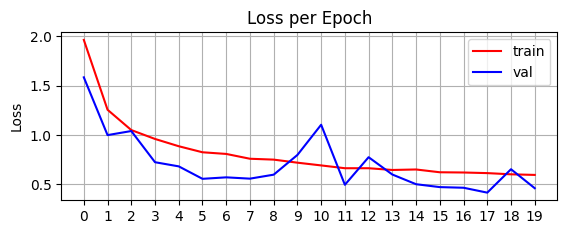

In [33]:
# Train and validate
torch.manual_seed(2023)
np.random.seed(2023)

# First make the model and put it on the device
model = PointNetSeg(k=4).to(device)
# model = PointNetSeg().to(device)

# Now define our loss criterion as cross entropy based on your previous code
criterion = lambda y_pred, y_true: cross_entropy_criterion(y_pred, y_true, class_weights)

# Now make our optimizer for this model
# TODO: pick an optimizer from torch.optim and set the learning rate
lr = None
optimizer = None

lr = 0.01
optimizer = optim.SGD(model.parameters(),lr=lr, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr = lr) 

# TODO: how many epochs to train for?
# Consider putting this code into a loop, 
# thus alternating between training for some number of epochs and validating
# epochs = None
epochs = 20
model = train(model, optimizer, criterion, plane_dataloader, device, valloader=plane_val_dataloader, epochs=epochs)

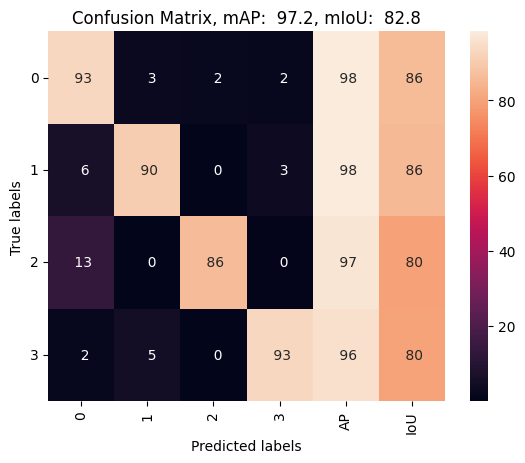

                   0: AP: 0.98, IoU: 0.86
                   1: AP: 0.98, IoU: 0.86
                   2: AP: 0.97, IoU: 0.80
                   3: AP: 0.96, IoU: 0.80
                mean: AP: 0.97, IoU: 0.83


In [34]:
classes = [
    '0',
    '1',
    '2',
    '3'
]
preds, gts = validate_model(plane_val_dataloader, model, classes, device, show_matrix=True)

In [35]:
# Visualize some predictions
for i in range(3):
    pts, gt_seg = plane_val_dataset[np.random.randint(len(plane_val_dataset))]
    vis_pred_vs_gt(pts, gt_seg, model)

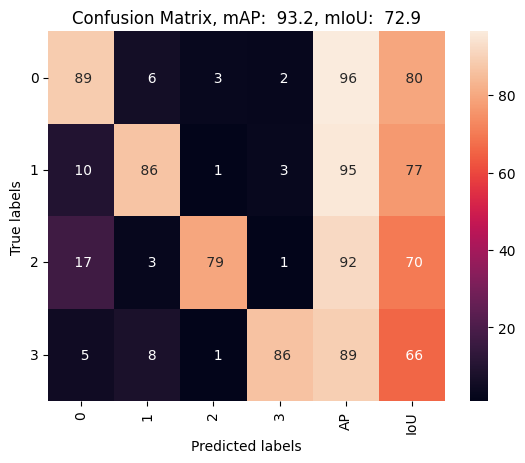

                   0: AP: 0.96, IoU: 0.80
                   1: AP: 0.95, IoU: 0.77
                   2: AP: 0.92, IoU: 0.70
                   3: AP: 0.89, IoU: 0.66
                mean: AP: 0.93, IoU: 0.73


In [36]:
test_dataset = ShapeNetDataset(root=DATASET_PATH, split='test', class_choice=['Airplane'], data_augmentation=False)
test_dataloader = data.DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)
preds, gts = validate_model(test_dataloader, model, classes, device, show_matrix=True)